In [1]:
import numpy as np
import transformers
import pandas as pd
import re
from colorama import Fore, Back, Style
import tensorflow as tf

In [2]:
tf.config.list_logical_devices('GPU')

[LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [3]:
dataset = pd.read_excel('dataset/maya_dataset.xlsx', engine = 'openpyxl')
dataset = dataset.iloc[:, 0:2]
df_1 = dataset.copy()
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
                                    u"\U0001F600-\U0001F64F" # emoticons
                                    u"\U0001F300-\U0001F5FF" # symbols & pictographs
                                    u"\U0001F680-\U0001F6FF" # transport & map symbols
                                    u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                                    u"\U0001F97A"
                                    u"\U00002639"
                                    u"\U0001F642"
                                    u"\U00002764"
                                    u"\U0001F600-\U000E007F"
                                    "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r' ',text)
def depunctuate(text):
    regrex_pattern = re.compile(pattern = "["u"\/"u"\\"u"\^"u"\!"u"\@"u"\+"u"\*"u"\="u"\%"u"\&"u"\:"u"\;"u"\_"u"\."u"\,"u"\("u"\)"u"\?"u"\।"u"\|"u"'"u"\-"u"\""u"]+")
    return regrex_pattern.sub(r' ',text)
def denumerize(text):
    regrex_pattern = re.compile(pattern = "[0-9০১২৩৪৫৬৭৮৯]+")
    return regrex_pattern.sub(r' ',text)
def remove_empty_string_literals(string_list):
    while("" in string_list) :
        string_list.remove("")
    return string_list

In [4]:
for i in range(df_1.shape[0]):
    df_1.iloc[i,0] = deEmojify(df_1.iloc[i,0])
df_2 = df_1.copy()

for i in range(df_2.shape[0]):
    df_2.iloc[i,0] = denumerize(df_2.iloc[i,0])
df_3 = df_2.copy()
df_3['length'] = [len(remove_empty_string_literals(post.split(' '))) for post in df_3.iloc[:, 0]]
LOWER_BOUND = 5
UPPER_BOUND = 300
df_4 = df_3[(df_3['length'] >= LOWER_BOUND) == True]
df_4 = df_4[(df_4['length'] <= UPPER_BOUND) == True]

df_5 = df_4.copy()

for i in range(df_5.shape[0]):
    df_5.iloc[i,0] = depunctuate(df_5.iloc[i,0])
print(df_5.shape)

(4876, 3)


In [5]:
#spell-correction

In [6]:
from bnlp.corpus.util import remove_stopwords
file = open('stopwords/stopwords-bn.txt', encoding = 'utf-8')
stopwords = []
for line in file:
    stopwords.append(line.strip())
file.close()
stopwords = list(filter(None, stopwords))
df_6 = df_5.iloc[:, 0:2].copy()
for i in range(df_6.shape[0]):
    df_6.iloc[i, 0] = ' '.join(remove_stopwords(df_6.iloc[i, 0], stopwords))
y = df_6.iloc[:, 1:2].values

corpus = df_6.iloc[:, 0].values
y = df_6.iloc[:, 1:2].values

/home/drr/.local/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [7]:
# one hot encoding y
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown = 'ignore')
y = np.array((enc.fit_transform(y)).toarray())

In [8]:
df_6['raw_posts'] = df_4.iloc[:, 0].values

In [9]:
df_6 = df_6.reindex(columns=['labels', 'posts', 'raw_posts'])
df_6.tail()

,labels,posts,raw_posts
4891,3,আসসালামু আলাইকুম সিজারে বাচ্চা হয়েছে বাচ্চা ইন...,আসসালামু আলাইকুম। আমার সিজারে বাচ্চা হয়েছে দ...
4892,3,গর্ভবতী অবস্থায় মানসিক অশান্তি ডিপ্রেশনে কান্ন...,"গর্ভবতী অবস্থায় মানসিক অশান্তি, ডিপ্রেশনে কান্..."
4893,4,মানুষিক সমস্যাতে আছি হয় মরে শান্তি,আমি মানুষিক অনেক সমস্যাতে আছি ... মনে হয় মরে ...
4894,4,হাই একজন বয়স এডমিশন দিব করোনার আটকে সবসময় ডিপ্...,হাই। আমি একজন মেয়ে। আমার বয়স বছর। আমি এবার...
4895,3,ছয় ডিপ্রেশনে ভুগছি চিকিৎসা নিয়েছি কিছুতেই হচ্ছ...,আমি ছয় বছর ধরে ডিপ্রেশনে ভুগছি।অনেক চিকিৎসা নি...


In [10]:
input_size = int(UPPER_BOUND + 5)
print(input_size)

305


In [11]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("sagorsarker/bangla-bert-base", add_special_tokens = True, 
                                                max_length = input_size, pad_to_max_length=True)
# X
sentences = df_6.iloc[:, -1:].values.tolist()

In [12]:
def tokenize(sentences, tokenizer):
    input_ids, input_masks, input_segments = [],[],[]
    for sentence in sentences:
        inputs = tokenizer.batch_encode_plus(sentence, add_special_tokens=True, 
                                             max_length = input_size,
                                             padding='max_length',
                                             return_attention_mask = True, 
                                             return_token_type_ids = True,
                                             truncation = True)

        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])

    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32'), np.asarray(input_segments, dtype='int32')

In [13]:
input_ids, input_masks, input_segments = tokenize(sentences = sentences, tokenizer = tokenizer)

In [14]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(sentences, y, test_size = 0.25, random_state = 0)

x_train = tokenize(x_train, tokenizer)
x_train = [np.squeeze(x_train[0]), np.squeeze(x_train[1]), np.squeeze(x_train[2])]

x_test = tokenize(x_test, tokenizer)
x_test = [np.squeeze(x_test[0]), np.squeeze(x_test[1]), np.squeeze(x_test[2])]

In [15]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                  classes = np.unique(np.reshape(enc.inverse_transform(y_train), y_train.shape[0])),
                                                  y = np.reshape(enc.inverse_transform(y_train), y_train.shape[0]))
class_weights = {0 : class_weights[0],
               1 : class_weights[1],
               2 : class_weights[2],
               3 : class_weights[3]}

# Callbacks



In [26]:
lr = 1e-4
ACCURACY_THRESHOLD = 0.85
class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs = {}): 
        if(logs.get('val_accuracy') > ACCURACY_THRESHOLD):   
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))   
            self.model.stop_training = True
acc_threshold = myCallback()

# save best model
from keras.callbacks import ModelCheckpoint
filepath = 'saved-models/BERT-BiGRU-test.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath = filepath, 
                             monitor = 'val_accuracy',
                             verbose = 1, 
                             save_best_only = True,
                             mode = 'max')


cosine_decay = tf.optimizers.schedules.CosineDecay(initial_learning_rate = lr, 
                                                   decay_steps = 1000)
lr_scheduler_1 = tf.keras.callbacks.LearningRateScheduler(cosine_decay)

cosine_decay_with_restarts = tf.optimizers.schedules.CosineDecayRestarts(initial_learning_rate = lr,
                                                                        first_decay_steps = 1000,
                                                                        m_mul = 0.1)
lr_scheduler_2 = tf.keras.callbacks.LearningRateScheduler(cosine_decay_with_restarts)


from keras.callbacks import TensorBoard
tensor_board = TensorBoard(log_dir = 'tb_logs_BERT-BiGRU',
                           update_freq = 1)
from keras.callbacks import EarlyStopping
earlystopping = EarlyStopping(monitor='val_loss', patience=10)

# Model training

In [27]:
transformer_model = transformers.TFAutoModel.from_pretrained('neuralspace-reverie/indic-transformers-bn-xlmroberta')

input_ids_in = tf.keras.layers.Input(shape=(input_size,), name='input_token', dtype=tf.int32)

input_masks_in = tf.keras.layers.Input(shape=(input_size,), name='masked_token', dtype=tf.int32)

input_segments_in = tf.keras.layers.Input(shape=(input_size,), name='segment_token', dtype=tf.int32)

from keras.regularizers import l2

embedding_layer = transformer_model(input_ids=input_ids_in, attention_mask=input_masks_in, token_type_ids = input_segments_in)[0]
# X = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(150, return_sequences=True, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))(embedding_layer)
# X = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(150, return_sequences=True, go_backwards=True, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))(X)
X = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(150, return_sequences=True, dropout=0.1))(embedding_layer)
X = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(150, return_sequences=True, go_backwards=True, dropout=0.1))(X)
X = tf.keras.layers.GlobalMaxPooling1D()(X)
X = tf.keras.layers.Dense(4096, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(X)
# X = tf.keras.layers.Dense(1024, activation='relu')(X)
# X = tf.keras.layers.Dense(1024, activation='relu')(X)
X = tf.keras.layers.Dropout(0.1)(X)
X = tf.keras.layers.Dense(4, activation='softmax')(X)

model = tf.keras.Model(inputs=[input_ids_in, input_masks_in, input_segments_in], outputs = X)

for layer in model.layers[:4]:
    layer.trainable = False


Some layers from the model checkpoint at neuralspace-reverie/indic-transformers-bn-xlmroberta were not used when initializing TFXLMRobertaModel: ['lm_head']
- This IS expected if you are initializing TFXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLMRobertaModel were initialized from the model checkpoint at neuralspace-reverie/indic-transformers-bn-xlmroberta.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


In [28]:
opt = tf.keras.optimizers.Adam(learning_rate=lr,
                              amsgrad=True,
                              name="Adam",)

model.compile(loss = 'categorical_crossentropy',
             optimizer = opt,
             weighted_metrics = 'accuracy')
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 305)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 305)]        0           []                               
                                                                                                  
 segment_token (InputLayer)     [(None, 305)]        0           []                               
                                                                                                  
 tfxlm_roberta_model_3 (TFXLMRo  TFBaseModelOutputWi  134490624  ['input_token[0][0]',            
 bertaModel)                    thPoolingAndCrossAt               'masked_token[0][0]',     

In [29]:
training = model.fit(x = x_train, y = y_train, batch_size = 8, 
                    epochs = 400, shuffle = True, verbose = 1, 
                    validation_split = 0.3,
                    class_weight = class_weights,
                    callbacks = [lr_scheduler_2, ])

Epoch 1/400
320/320 [==============================] - 56s 154ms/step - loss: 4.9495 - accuracy: 0.4084 - val_loss: 3.6755 - val_accuracy: 0.5200 - lr: 1.0000e-04
Epoch 2/400
320/320 [==============================] - 48s 149ms/step - loss: 3.0218 - accuracy: 0.5252 - val_loss: 2.4052 - val_accuracy: 0.6148 - lr: 1.0000e-04
Epoch 3/400
320/320 [==============================] - 48s 149ms/step - loss: 2.1640 - accuracy: 0.5523 - val_loss: 1.9112 - val_accuracy: 0.5911 - lr: 9.9999e-05
Epoch 4/400
320/320 [==============================] - 48s 149ms/step - loss: 1.6808 - accuracy: 0.5632 - val_loss: 1.4784 - val_accuracy: 0.6275 - lr: 9.9998e-05
Epoch 5/400
320/320 [==============================] - 48s 149ms/step - loss: 1.3705 - accuracy: 0.6255 - val_loss: 1.2231 - val_accuracy: 0.6648 - lr: 9.9996e-05
Epoch 6/400
320/320 [==============================] - 47s 149ms/step - loss: 1.1475 - accuracy: 0.6540 - val_loss: 1.0680 - val_accuracy: 0.6821 - lr: 9.9994e-05
Epoch 7/400
320/320 [=

320/320 [==============================] - 49s 154ms/step - loss: 0.0640 - accuracy: 0.9924 - val_loss: 1.0105 - val_accuracy: 0.7641 - lr: 9.9384e-05
Epoch 52/400
320/320 [==============================] - 48s 149ms/step - loss: 0.0597 - accuracy: 0.9951 - val_loss: 1.0696 - val_accuracy: 0.7750 - lr: 9.9360e-05
Epoch 53/400
320/320 [==============================] - 48s 149ms/step - loss: 0.0636 - accuracy: 0.9922 - val_loss: 1.0175 - val_accuracy: 0.7614 - lr: 9.9334e-05
Epoch 54/400
320/320 [==============================] - 48s 149ms/step - loss: 0.0600 - accuracy: 0.9940 - val_loss: 1.0470 - val_accuracy: 0.7842 - lr: 9.9308e-05
Epoch 55/400
320/320 [==============================] - 48s 149ms/step - loss: 0.0549 - accuracy: 0.9958 - val_loss: 1.0820 - val_accuracy: 0.7796 - lr: 9.9282e-05
Epoch 56/400
320/320 [==============================] - 48s 149ms/step - loss: 0.0541 - accuracy: 0.9955 - val_loss: 1.0855 - val_accuracy: 0.7823 - lr: 9.9255e-05
Epoch 57/400
320/320 [=======

320/320 [==============================] - 47s 148ms/step - loss: 0.0222 - accuracy: 0.9990 - val_loss: 1.0649 - val_accuracy: 0.7832 - lr: 9.7553e-05
Epoch 102/400
320/320 [==============================] - 48s 149ms/step - loss: 0.0204 - accuracy: 0.9989 - val_loss: 1.0414 - val_accuracy: 0.7796 - lr: 9.7504e-05
Epoch 103/400
320/320 [==============================] - 48s 149ms/step - loss: 0.0192 - accuracy: 0.9995 - val_loss: 1.0457 - val_accuracy: 0.7851 - lr: 9.7455e-05
Epoch 104/400
320/320 [==============================] - 48s 149ms/step - loss: 0.0195 - accuracy: 0.9997 - val_loss: 1.0545 - val_accuracy: 0.7796 - lr: 9.7405e-05
Epoch 105/400
320/320 [==============================] - 48s 149ms/step - loss: 0.0187 - accuracy: 0.9995 - val_loss: 1.0469 - val_accuracy: 0.7769 - lr: 9.7355e-05
Epoch 106/400
320/320 [==============================] - 48s 150ms/step - loss: 0.0198 - accuracy: 0.9992 - val_loss: 1.1197 - val_accuracy: 0.7668 - lr: 9.7304e-05
Epoch 107/400
320/320 [=

Epoch 151/400
320/320 [==============================] - 47s 147ms/step - loss: 0.0141 - accuracy: 1.0000 - val_loss: 1.1171 - val_accuracy: 0.7750 - lr: 9.4550e-05
Epoch 152/400
320/320 [==============================] - 47s 147ms/step - loss: 0.0217 - accuracy: 0.9970 - val_loss: 1.2461 - val_accuracy: 0.7778 - lr: 9.4479e-05
Epoch 153/400
320/320 [==============================] - 47s 147ms/step - loss: 0.0240 - accuracy: 0.9955 - val_loss: 1.2039 - val_accuracy: 0.7796 - lr: 9.4407e-05
Epoch 154/400
320/320 [==============================] - 47s 147ms/step - loss: 0.0233 - accuracy: 0.9984 - val_loss: 1.2009 - val_accuracy: 0.7732 - lr: 9.4334e-05
Epoch 155/400
320/320 [==============================] - 47s 147ms/step - loss: 0.0220 - accuracy: 0.9973 - val_loss: 1.2031 - val_accuracy: 0.7814 - lr: 9.4262e-05
Epoch 156/400
320/320 [==============================] - 47s 147ms/step - loss: 0.0161 - accuracy: 0.9989 - val_loss: 1.1428 - val_accuracy: 0.7805 - lr: 9.4188e-05
Epoch 157/

Epoch 201/400
320/320 [==============================] - 47s 147ms/step - loss: 0.0155 - accuracy: 0.9982 - val_loss: 1.1589 - val_accuracy: 0.7787 - lr: 9.0451e-05
Epoch 202/400
320/320 [==============================] - 47s 147ms/step - loss: 0.0118 - accuracy: 0.9990 - val_loss: 1.1694 - val_accuracy: 0.7741 - lr: 9.0358e-05
Epoch 203/400
320/320 [==============================] - 47s 147ms/step - loss: 0.0160 - accuracy: 0.9978 - val_loss: 1.1660 - val_accuracy: 0.7632 - lr: 9.0265e-05
Epoch 204/400
320/320 [==============================] - 47s 146ms/step - loss: 0.0125 - accuracy: 0.9989 - val_loss: 1.1580 - val_accuracy: 0.7778 - lr: 9.0172e-05
Epoch 205/400
320/320 [==============================] - 47s 146ms/step - loss: 0.0131 - accuracy: 0.9985 - val_loss: 1.2371 - val_accuracy: 0.7805 - lr: 9.0078e-05
Epoch 206/400
320/320 [==============================] - 47s 147ms/step - loss: 0.0104 - accuracy: 0.9995 - val_loss: 1.1964 - val_accuracy: 0.7796 - lr: 8.9984e-05
Epoch 207/

Epoch 251/400
320/320 [==============================] - 47s 147ms/step - loss: 0.0220 - accuracy: 0.9950 - val_loss: 1.2947 - val_accuracy: 0.7723 - lr: 8.5355e-05
Epoch 252/400
320/320 [==============================] - 47s 146ms/step - loss: 0.0212 - accuracy: 0.9958 - val_loss: 1.2489 - val_accuracy: 0.7851 - lr: 8.5244e-05
Epoch 253/400
320/320 [==============================] - 47s 147ms/step - loss: 0.0123 - accuracy: 0.9992 - val_loss: 1.2447 - val_accuracy: 0.7787 - lr: 8.5132e-05
Epoch 254/400
320/320 [==============================] - 47s 147ms/step - loss: 0.0118 - accuracy: 0.9992 - val_loss: 1.2709 - val_accuracy: 0.7851 - lr: 8.5021e-05
Epoch 255/400
320/320 [==============================] - 47s 147ms/step - loss: 0.0141 - accuracy: 0.9981 - val_loss: 1.3079 - val_accuracy: 0.7778 - lr: 8.4908e-05
Epoch 256/400
320/320 [==============================] - 47s 147ms/step - loss: 0.0103 - accuracy: 0.9994 - val_loss: 1.2122 - val_accuracy: 0.7860 - lr: 8.4796e-05
Epoch 257/

Epoch 301/400
320/320 [==============================] - 47s 146ms/step - loss: 0.0055 - accuracy: 1.0000 - val_loss: 1.1992 - val_accuracy: 0.7832 - lr: 7.9389e-05
Epoch 302/400
320/320 [==============================] - 47s 146ms/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 1.1628 - val_accuracy: 0.7851 - lr: 7.9262e-05
Epoch 303/400
320/320 [==============================] - 47s 146ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.1684 - val_accuracy: 0.7814 - lr: 7.9135e-05
Epoch 304/400
320/320 [==============================] - 47s 147ms/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 1.1797 - val_accuracy: 0.7860 - lr: 7.9007e-05
Epoch 305/400
320/320 [==============================] - 47s 147ms/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 1.1875 - val_accuracy: 0.7832 - lr: 7.8879e-05
Epoch 306/400
320/320 [==============================] - 47s 147ms/step - loss: 0.0052 - accuracy: 1.0000 - val_loss: 1.1669 - val_accuracy: 0.7796 - lr: 7.8750e-05
Epoch 307/

Epoch 351/400
320/320 [==============================] - 47s 147ms/step - loss: 0.0080 - accuracy: 0.9997 - val_loss: 1.2757 - val_accuracy: 0.7741 - lr: 7.2700e-05
Epoch 352/400
320/320 [==============================] - 47s 147ms/step - loss: 0.0073 - accuracy: 0.9995 - val_loss: 1.2339 - val_accuracy: 0.7796 - lr: 7.2559e-05
Epoch 353/400
320/320 [==============================] - 47s 147ms/step - loss: 0.0066 - accuracy: 1.0000 - val_loss: 1.2082 - val_accuracy: 0.7851 - lr: 7.2419e-05
Epoch 354/400
320/320 [==============================] - 47s 147ms/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 1.2047 - val_accuracy: 0.7842 - lr: 7.2279e-05
Epoch 355/400
320/320 [==============================] - 47s 147ms/step - loss: 0.0055 - accuracy: 1.0000 - val_loss: 1.1768 - val_accuracy: 0.7823 - lr: 7.2138e-05
Epoch 356/400
320/320 [==============================] - 47s 147ms/step - loss: 0.0057 - accuracy: 1.0000 - val_loss: 1.1799 - val_accuracy: 0.7851 - lr: 7.1997e-05
Epoch 357/

In [30]:
predicted_prob = model.predict(x_test)
y_pred = np.argmax(predicted_prob, axis = 1)
from sklearn.metrics import confusion_matrix, classification_report
cr = classification_report(enc.inverse_transform(y_test), y_pred+1)
cm = confusion_matrix(enc.inverse_transform(y_test), y_pred+1)
print('Classification Report', cr, sep = '\n')
print(Fore.GREEN+'Confusion Matrix', cm, '', sep = '\n')

Classification Report
              precision    recall  f1-score   support

           1       0.83      0.90      0.86       508
           2       0.75      0.79      0.77       378
           3       0.58      0.47      0.52       191
           4       0.94      0.76      0.84       142

    accuracy                           0.78      1219
   macro avg       0.77      0.73      0.75      1219
weighted avg       0.78      0.78      0.78      1219

Confusion Matrix
[[457  26  22   3]
 [ 44 299  34   1]
 [ 32  67  89   3]
 [ 17   8   9 108]]



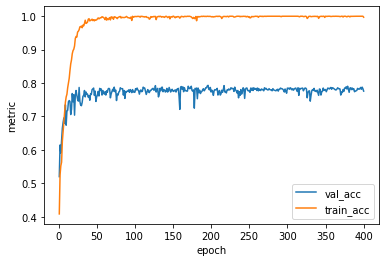

In [31]:
val_acc = training.history['val_accuracy']
acc = training.history['accuracy']
ep = np.arange(len(acc))+1
import matplotlib.pyplot as plt
plt.figure().patch.set_facecolor('white')
plt.plot(ep, val_acc, label = 'val_acc')
plt.plot(ep, acc, label = 'train_acc')
plt.xlabel('epoch')
plt.ylabel('metric')
plt.legend()
plt.show()

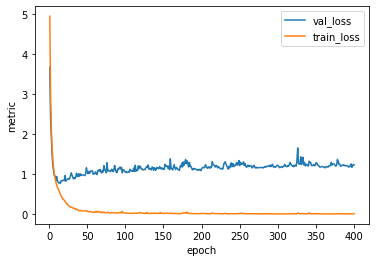

In [32]:
val_loss = training.history['val_loss']
loss = training.history['loss']
ep = np.arange(len(loss))+1
import matplotlib.pyplot as plt
plt.figure().patch.set_facecolor('white')
plt.plot(ep, val_loss, label = 'val_loss')
plt.plot(ep, loss, label = 'train_loss')
plt.xlabel('epoch')
plt.ylabel('metric')
plt.legend()
plt.show()